<a href="https://colab.research.google.com/github/zxzinn/hai-dataset-analysis/blob/master/hai_dataset_analysis_advanced_test_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HAI-20.07 Dataset Analysis with Advanced Efficient Architectures

This notebook analyzes the HAI-20.07 dataset and implements advanced but computationally efficient architectures for attack detection in industrial control systems. The focus is on achieving high performance with low computational resources ("低消耗高效能").

## 0. Setup and Configuration

In [1]:
# Check if running in Colab
import sys
IN_COLAB = 'google.colab' in sys.modules
print(f"Running in Google Colab: {IN_COLAB}")

if IN_COLAB:
    # Install required packages
    !pip install -q xgboost scikit-learn matplotlib seaborn torch tensorflow tqdm psutil memory_profiler kaggle

Running in Google Colab: True


### Download Dataset from Kaggle

To download the HAI Security Dataset from Kaggle, you need to provide your Kaggle API credentials.

In [2]:
# 掛載 Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 安裝 Kaggle API 如果尚未安裝
!pip install kaggle

# 創建 Kaggle API 配置目錄
!mkdir -p ~/.kaggle

# 要求使用者上傳 kaggle.json 檔案
from google.colab import files
print("請上傳您的 kaggle.json 檔案 (可從 Kaggle > 個人資料 > Account > API > Create New API Token 獲取)")
uploaded = files.upload()  # 這會打開一個檔案上傳對話框

# 檢查是否有正確的檔案被上傳
import os
if 'kaggle.json' in uploaded:
    # 複製到 Kaggle 的配置目錄
    !cp kaggle.json ~/.kaggle/kaggle.json
    # 設置正確的權限
    !chmod 600 ~/.kaggle/kaggle.json
    print("憑證已成功設置")
else:
    print("未找到 kaggle.json 檔案，請確保上傳正確的檔案")
    exit()

# 設定下載目標目錄
target_dir = '/content/drive/My Drive/kaggle_datasets'
!mkdir -p {target_dir}

# 使用 Kaggle API 下載資料集
!kaggle datasets download icsdataset/hai-security-dataset -p {target_dir}

# 解壓縮
!unzip -q {target_dir}/hai-security-dataset.zip -d {target_dir}

print(f"資料集已下載並解壓縮到 {target_dir}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
請上傳您的 kaggle.json 檔案 (可從 Kaggle > 個人資料 > Account > API > Create New API Token 獲取)


Saving kaggle.json to kaggle (4).json
未找到 kaggle.json 檔案，請確保上傳正確的檔案
mkdir: cannot create directory ‘/content/drive/My’: Operation not supported
usage: kaggle [-h] [-v] [-W] {competitions,c,datasets,d,kernels,k,models,m,files,f,config} ...
kaggle: error: unrecognized arguments: Drive/kaggle_datasets
unzip:  cannot find or open /content/drive/My, /content/drive/My.zip or /content/drive/My.ZIP.
資料集已下載並解壓縮到 /content/drive/My Drive/kaggle_datasets


In [35]:
# Download and extract the HAI Security Dataset
if IN_COLAB:
    import os

    # Check if dataset already exists
    if not os.path.exists('/content/hai-security-dataset'):
        print("Downloading HAI Security Dataset from Kaggle...")
        !kaggle datasets download icsdataset/hai-security-dataset -p /content/

        print("\nExtracting dataset...")
        !unzip -q /content/hai-security-dataset.zip -d /content/
        print("Dataset extracted successfully.")
    else:
        print("HAI Security Dataset already exists in /content/hai-security-dataset")

    # List the contents of the dataset directory
    print("\nContents of the dataset directory:")
    !ls -la /content/hai-security-dataset/hai-20.07

Dataset URL: https://www.kaggle.com/datasets/icsdataset/hai-security-dataset
License(s): CC-BY-SA-4.0
hai-security-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)

Extracting dataset...
replace /content/graph/boiler/dcs_1001h.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: Dataset extracted successfully.

Contents of the dataset directory:
ls: cannot access '/content/hai-security-dataset/hai-20.07': No such file or directory


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import xgboost as xgb
import warnings
import time
import os
import psutil
from tqdm.notebook import tqdm

# Deep learning libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Flatten, Input, Dropout, BatchNormalization

# Set display options
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
tf.random.set_seed(42)

# Check for GPU availability
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU device name: {torch.cuda.get_device_name(0)}")

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

CUDA available: True
GPU device name: NVIDIA A100-SXM4-40GB
Using device: cuda:0


In [2]:
# Define a function to measure memory usage
def get_memory_usage():
    """Get current memory usage in MB"""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / (1024 * 1024)  # Convert to MB

# Define a class to track model performance and efficiency
class ModelEvaluator:
    def __init__(self):
        self.results = []

    def add_result(self, model_name, accuracy, precision, recall, f1, training_time, inference_time, memory_usage):
        self.results.append({
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'Training Time (s)': training_time,
            'Inference Time (ms)': inference_time * 1000,  # Convert to milliseconds
            'Memory Usage (MB)': memory_usage
        })

    def get_results_df(self):
        return pd.DataFrame(self.results)

    def plot_comparison(self):
        results_df = self.get_results_df()

        # Plot performance metrics
        plt.figure(figsize=(15, 10))

        # Performance metrics
        plt.subplot(2, 2, 1)
        performance_df = results_df.melt(id_vars=['Model'],
                                        value_vars=['Accuracy', 'Precision', 'Recall', 'F1 Score'],
                                        var_name='Metric', value_name='Value')
        sns.barplot(x='Model', y='Value', hue='Metric', data=performance_df)
        plt.title('Performance Metrics Comparison')
        plt.ylim(0.8, 1.0)  # Adjust as needed
        plt.xticks(rotation=45)
        plt.legend(loc='lower right')

        # Training time
        plt.subplot(2, 2, 2)
        sns.barplot(x='Model', y='Training Time (s)', data=results_df)
        plt.title('Training Time Comparison (seconds)')
        plt.xticks(rotation=45)
        plt.yscale('log')  # Log scale for better visualization

        # Inference time
        plt.subplot(2, 2, 3)
        sns.barplot(x='Model', y='Inference Time (ms)', data=results_df)
        plt.title('Inference Time Comparison (milliseconds)')
        plt.xticks(rotation=45)
        plt.yscale('log')  # Log scale for better visualization

        # Memory usage
        plt.subplot(2, 2, 4)
        sns.barplot(x='Model', y='Memory Usage (MB)', data=results_df)
        plt.title('Memory Usage Comparison (MB)')
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

# Initialize the evaluator
evaluator = ModelEvaluator()

## 1. Load and Preprocess Data

In [3]:

data_path = '/content/drive/MyDrive/kaggle_datasets/hai-20.07/'

# Load training datasets
train1 = pd.read_csv(f'{data_path}train1.csv', sep=';')
train2 = pd.read_csv(f'{data_path}train2.csv', sep=';')

# Load testing datasets
test1 = pd.read_csv(f'{data_path}test1.csv', sep=';')
test2 = pd.read_csv(f'{data_path}test2.csv', sep=';')

# Display basic information about the datasets
print("Training Dataset 1 Shape:", train1.shape)
print("Training Dataset 2 Shape:", train2.shape)
print("Testing Dataset 1 Shape:", test1.shape)
print("Testing Dataset 2 Shape:", test2.shape)

Training Dataset 1 Shape: (309600, 64)
Training Dataset 2 Shape: (241200, 64)
Testing Dataset 1 Shape: (291600, 64)
Testing Dataset 2 Shape: (153000, 64)


In [4]:
# Convert time column to datetime
train1['time'] = pd.to_datetime(train1['time'])
train2['time'] = pd.to_datetime(train2['time'])
test1['time'] = pd.to_datetime(test1['time'])
test2['time'] = pd.to_datetime(test2['time'])

# Identify feature columns (excluding time and attack labels)
feature_columns = [col for col in train1.columns if col not in ['time', 'attack', 'attack_P1', 'attack_P2', 'attack_P3']]
print(f"Number of feature columns: {len(feature_columns)}")
print(f"First few feature columns: {feature_columns[:5]}...")

# Check attack distribution
print("\nAttack distribution in train1:")
print(train1['attack'].value_counts(normalize=True) * 100)
print("\nAttack distribution in test1:")
print(test1['attack'].value_counts(normalize=True) * 100)

Number of feature columns: 59
First few feature columns: ['P1_B2004', 'P1_B2016', 'P1_B3004', 'P1_B3005', 'P1_B4002']...

Attack distribution in train1:
attack
0    100.0
Name: proportion, dtype: float64

Attack distribution in test1:
attack
0    96.04321
1     3.95679
Name: proportion, dtype: float64


In [5]:
# Combine training datasets
train_combined = pd.concat([train1, train2], ignore_index=True)

# Combine testing datasets
test_combined = pd.concat([test1, test2], ignore_index=True)

# Extract features and target
X_train = train_combined[feature_columns]
y_train = train_combined['attack']

X_test = test_combined[feature_columns]
y_test = test_combined['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

X_train_scaled shape: (550800, 59)
X_test_scaled shape: (444600, 59)


## 2. Advanced Feature Engineering

In [6]:
# Create a function to add time-based features
def add_time_features(df):
    # Make a copy to avoid modifying the original dataframe
    df_copy = df.copy()

    # Extract time-based features
    df_copy['hour'] = df_copy['time'].dt.hour
    df_copy['minute'] = df_copy['time'].dt.minute
    df_copy['second'] = df_copy['time'].dt.second
    df_copy['day_of_week'] = df_copy['time'].dt.dayofweek

    # Add cyclical time features (to capture periodicity)
    df_copy['hour_sin'] = np.sin(2 * np.pi * df_copy['hour'] / 24)
    df_copy['hour_cos'] = np.cos(2 * np.pi * df_copy['hour'] / 24)
    df_copy['minute_sin'] = np.sin(2 * np.pi * df_copy['minute'] / 60)
    df_copy['minute_cos'] = np.cos(2 * np.pi * df_copy['minute'] / 60)

    return df_copy

# Create a function to add rolling window statistics
def add_rolling_features(df, window_sizes=[5, 10, 20]):
    # Make a copy to avoid modifying the original dataframe
    df_copy = df.copy()

    # Sort by time to ensure correct rolling window calculation
    df_copy = df_copy.sort_values('time')

    # Select features for rolling statistics (exclude time and attack columns)
    rolling_features = [col for col in df_copy.columns if col not in ['time', 'attack', 'attack_P1', 'attack_P2', 'attack_P3']]

    # Use only the top 5 most important features for rolling statistics to keep it efficient
    top_features = rolling_features[:5]  # In a real scenario, you would select based on feature importance

    # Calculate rolling statistics for different window sizes
    for window_size in window_sizes:
        for feature in top_features:
            df_copy[f'{feature}_rolling_mean_{window_size}'] = df_copy[feature].rolling(window=window_size).mean()
            df_copy[f'{feature}_rolling_std_{window_size}'] = df_copy[feature].rolling(window=window_size).std()

    # Drop NaN values created by rolling window
    df_copy = df_copy.dropna()

    return df_copy

# Create a function to add lag features
def add_lag_features(df, lag_steps=[1, 2, 3]):
    # Make a copy to avoid modifying the original dataframe
    df_copy = df.copy()

    # Sort by time to ensure correct lag calculation
    df_copy = df_copy.sort_values('time')

    # Select features for lag (exclude time and attack columns)
    lag_features = [col for col in df_copy.columns if col not in ['time', 'attack', 'attack_P1', 'attack_P2', 'attack_P3']]

    # Use only the top 5 most important features for lag to keep it efficient
    top_features = lag_features[:5]  # In a real scenario, you would select based on feature importance

    # Calculate lag features
    for lag in lag_steps:
        for feature in top_features:
            df_copy[f'{feature}_lag_{lag}'] = df_copy[feature].shift(lag)

    # Drop NaN values created by lag
    df_copy = df_copy.dropna()

    return df_copy

In [7]:
# Apply all feature engineering steps
print("Applying feature engineering...")
# Add time features
train_features = add_time_features(train_combined)
test_features = add_time_features(test_combined)

# Add rolling features
train_features = add_rolling_features(train_features)
test_features = add_rolling_features(test_features)

# Add lag features
train_features = add_lag_features(train_features)
test_features = add_lag_features(test_features)

# Extract features and target from the enhanced datasets
feature_columns_enhanced = [col for col in train_features.columns
                           if col not in ['time', 'attack', 'attack_P1', 'attack_P2', 'attack_P3']]

X_train_enhanced = train_features[feature_columns_enhanced]
y_train_enhanced = train_features['attack']

X_test_enhanced = test_features[feature_columns_enhanced]
y_test_enhanced = test_features['attack']

# Scale the enhanced features
scaler_enhanced = StandardScaler()
X_train_enhanced_scaled = scaler_enhanced.fit_transform(X_train_enhanced)
X_test_enhanced_scaled = scaler_enhanced.transform(X_test_enhanced)

print("X_train_enhanced_scaled shape:", X_train_enhanced_scaled.shape)
print("X_test_enhanced_scaled shape:", X_test_enhanced_scaled.shape)
print(f"Number of enhanced features: {X_train_enhanced_scaled.shape[1]}")

Applying feature engineering...
X_train_enhanced_scaled shape: (550778, 112)
X_test_enhanced_scaled shape: (444578, 112)
Number of enhanced features: 112


## 3. Prepare Data for Sequence Models

In [8]:
# Function to create sequences for time series models
def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Create sequences for training and testing
TIME_STEPS = 10
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values, TIME_STEPS)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, TIME_STEPS)

print("X_train_seq shape:", X_train_seq.shape)
print("y_train_seq shape:", y_train_seq.shape)
print("X_test_seq shape:", X_test_seq.shape)
print("y_test_seq shape:", y_test_seq.shape)

X_train_seq shape: (550790, 10, 59)
y_train_seq shape: (550790,)
X_test_seq shape: (444590, 10, 59)
y_test_seq shape: (444590,)


## 4. Model 1: Lightweight Temporal Convolutional Network (TCN)

In [9]:
# Define a lightweight TCN model using PyTorch
class LightweightTCN(nn.Module):
    def __init__(self, input_size, num_channels=[32, 16], kernel_size=3, dropout=0.2):
        super(LightweightTCN, self).__init__()
        layers = []
        num_levels = len(num_channels)

        # Input layer
        layers.append(nn.Conv1d(in_channels=input_size, out_channels=num_channels[0], kernel_size=kernel_size, padding=kernel_size//2))
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm1d(num_channels[0]))
        layers.append(nn.Dropout(dropout))

        # Hidden layers
        for i in range(num_levels - 1):
            dilation_size = 2 ** i
            in_channels = num_channels[i]
            out_channels = num_channels[i + 1]
            layers.append(nn.Conv1d(in_channels=in_channels, out_channels=out_channels,
                                   kernel_size=kernel_size, padding=dilation_size, dilation=dilation_size))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(out_channels))
            layers.append(nn.Dropout(dropout))

        self.network = nn.Sequential(*layers)
        self.linear = nn.Linear(num_channels[-1], 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x shape: [batch, time_steps, features]
        # Convert to [batch, features, time_steps] for Conv1D
        x = x.permute(0, 2, 1)
        x = self.network(x)
        # Global average pooling
        x = torch.mean(x, dim=2)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

In [10]:
# Train the TCN model
def train_tcn_model(X_train, y_train, X_test, y_test):
    # Convert data to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
    X_test_tensor = torch.FloatTensor(X_test)

    # Create DataLoader for batch processing
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    # Initialize model, loss function, and optimizer
    input_size = X_train.shape[2]  # Number of features
    model = LightweightTCN(input_size).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Measure memory usage before training
    memory_before = get_memory_usage()

    # Train the model
    start_time = time.time()
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_dataset)
        if (epoch + 1) % 2 == 0 or epoch == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    training_time = time.time() - start_time
    print(f"Training time: {training_time:.2f} seconds")

    # Measure memory usage after training
    memory_after = get_memory_usage()
    memory_used = memory_after - memory_before
    print(f"Memory used: {memory_used:.2f} MB")

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        # Measure inference time
        inference_start = time.time()
        X_test_tensor = X_test_tensor.to(device)
        y_pred_proba = model(X_test_tensor).cpu().numpy()
        inference_time = (time.time() - inference_start) / len(X_test_tensor)
        print(f"Average inference time per sample: {inference_time*1000:.4f} ms")

        y_pred = (y_pred_proba > 0.5).astype(int).reshape(-1)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = classification_report(y_test, y_pred, output_dict=True)['1']['precision']
    recall = classification_report(y_test, y_pred, output_dict=True)['1']['recall']
    f1 = f1_score(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Add results to evaluator
    evaluator.add_result('Lightweight TCN', accuracy, precision, recall, f1,
                        training_time, inference_time, memory_used)

    return model, y_pred, y_pred_proba

# Train the TCN model
print("Training Lightweight TCN model...")
tcn_model, y_pred_tcn, y_prob_tcn = train_tcn_model(X_train_seq, y_train_seq, X_test_seq, y_test_seq)

Training Lightweight TCN model...
Epoch 1/10, Loss: 0.0153
Epoch 2/10, Loss: 0.0004
Epoch 4/10, Loss: 0.0002
Epoch 6/10, Loss: 0.0002
Epoch 8/10, Loss: 0.0002
Epoch 10/10, Loss: 0.0001
Training time: 251.22 seconds
Memory used: 379.73 MB
Average inference time per sample: 0.0008 ms
Accuracy: 0.9764
Precision: 0.9498
Recall: 0.4224
F1 Score: 0.5848


## 5. Model 2: Optimized LSTM with Attention

In [11]:
# Define a custom attention layer for Keras
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        # Alignment scores. Shape: (batch_size, seq_len, 1)
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)

        # Remove the last dimension. Shape: (batch_size, seq_len)
        e = tf.keras.backend.squeeze(e, axis=-1)

        # Compute the weights. Shape: (batch_size, seq_len)
        alpha = tf.keras.backend.softmax(e)

        # Shape: (batch_size, seq_len, 1)
        alpha_expanded = tf.keras.backend.expand_dims(alpha)

        # Compute the context vector. Shape: (batch_size, features)
        context = tf.keras.backend.sum(x * alpha_expanded, axis=1)

        return context

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

In [19]:
# Completely disable cuDNN at the beginning of the code
import os
os.environ['TF_DISABLE_CUDNN'] = '1'  # Disable cuDNN
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # This will completely disable GPU

import tensorflow as tf
import numpy as np
import time
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Define function to get memory usage
def get_memory_usage():
    import psutil
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024  # Return in MB

# Use a simplified custom attention mechanism instead of AttentionLayer
def attention_mechanism(inputs):
    # Simplified attention implementation
    from tensorflow.keras.layers import Dense, Multiply, Activation, Permute, Reshape

    # Calculate attention weights
    attention = Dense(1, activation='tanh')(inputs)
    attention = Activation('softmax')(attention)

    # Apply attention weights
    return Multiply()([inputs, attention])

# Redefine the model using CPU-only version
def create_lstm_attention_model(input_shape):
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, GlobalAveragePooling1D

    # Force CPU usage with a simplified model
    with tf.device('/CPU:0'):
        # Input layer
        inputs = Input(shape=input_shape)

        # Use simpler recurrent layer (SimpleRNN instead of LSTM)
        from tensorflow.keras.layers import SimpleRNN
        rnn_out = SimpleRNN(32, return_sequences=True)(inputs)

        # Simplified attention or directly use pooling
        # attention_out = attention_mechanism(rnn_out)  # Use custom attention
        attention_out = GlobalAveragePooling1D()(rnn_out)  # Or simply use global average pooling

        # Output layer
        x = Dense(16, activation='relu')(attention_out)
        x = Dropout(0.2)(x)
        outputs = Dense(1, activation='sigmoid')(x)

        # Create model
        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

    return model

# Train model function
def train_lstm_model(X_train, y_train, X_test, y_test):
    # Ensure running on CPU
    with tf.device('/CPU:0'):
        # Calculate memory usage before training
        memory_before = get_memory_usage()

        # Create model
        input_shape = (X_train.shape[1], X_train.shape[2])
        model = create_lstm_attention_model(input_shape)

        # Train model
        start_time = time.time()
        history = model.fit(
            X_train, y_train,
            epochs=10,
            batch_size=64,
            validation_split=0.1,
            verbose=1
        )

        training_time = time.time() - start_time
        print(f"Training time: {training_time:.2f} seconds")

        # Calculate memory usage after training
        memory_after = get_memory_usage()
        memory_used = memory_after - memory_before
        print(f"Memory used: {memory_used:.2f} MB")

        # Evaluate model
        inference_start = time.time()
        y_pred_proba = model.predict(X_test)
        inference_time = (time.time() - inference_start) / len(X_test)
        print(f"Average inference time per sample: {inference_time*1000:.4f} ms")

        y_pred = (y_pred_proba > 0.5).astype(int).reshape(-1)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = classification_report(y_test, y_pred, output_dict=True)['1']['precision']
        recall = classification_report(y_test, y_pred, output_dict=True)['1']['recall']
        f1 = f1_score(y_test, y_pred)

        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

        # Add results to evaluator
        try:
            evaluator.add_result('LSTM with Attention', accuracy, precision, recall, f1,
                            training_time, inference_time, memory_used)
        except:
            print("Evaluator object not found, skipping result addition")

        return model, y_pred, y_pred_proba

# Train the model
print("Training Optimized LSTM with Attention model...")
lstm_model, y_pred_lstm, y_prob_lstm = train_lstm_model(X_train_seq, y_train_seq, X_test_seq, y_test_seq)

Training Optimized LSTM with Attention model...
Epoch 1/10
7746/7746 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.9967 - loss: 0.0219 - val_accuracy: 1.0000 - val_loss: 3.6467e-05
Epoch 2/10
7746/7746 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9998 - loss: 8.9087e-04 - val_accuracy: 1.0000 - val_loss: 6.5981e-08
Epoch 3/10
7746/7746 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.9999 - loss: 5.3213e-04 - val_accuracy: 1.0000 - val_loss: 6.9233e-08
Epoch 4/10
7746/7746 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.9999 - loss: 5.2509e-04 - val_accuracy: 1.0000 - val_loss: 6.0065e-06
Epoch 5/10
7746/7746 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.9999 - loss: 4.1659e-04 - val_accuracy: 1.0000 - val_loss: 1.0758e-08
Epoch 6/10
7746/7746 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.9999 - loss: 2.7067e-04 - val_accuracy: 1.0000 - val_loss: 1.7638e-08
Epoch 7/10
7746/7746 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.9999 - loss: 3.0740e-04 - val_accuracy: 1.0000 - val_

## 6. Model 3: Efficient Ensemble Method

In [20]:
# Define an efficient ensemble method
def train_efficient_ensemble(X_train, y_train, X_test, y_test):
    # Measure memory usage before training
    memory_before = get_memory_usage()

    # Train XGBoost model with GPU acceleration
    start_time = time.time()
    xgb_model = xgb.XGBClassifier(
        n_estimators=50,  # Reduced number of estimators for efficiency
        max_depth=5,      # Reduced depth for efficiency
        learning_rate=0.1,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss',
        tree_method='gpu_hist' if torch.cuda.is_available() else 'hist'  # Use GPU if available
    )
    xgb_model.fit(X_train, y_train)

    # Train a small Random Forest model
    from sklearn.ensemble import RandomForestClassifier
    rf_model = RandomForestClassifier(
        n_estimators=50,  # Reduced number of estimators for efficiency
        max_depth=5,      # Reduced depth for efficiency
        random_state=42,
        n_jobs=-1         # Use all available cores
    )
    rf_model.fit(X_train, y_train)

    # Train a small Gradient Boosting model
    from sklearn.ensemble import GradientBoostingClassifier
    gb_model = GradientBoostingClassifier(
        n_estimators=50,  # Reduced number of estimators for efficiency
        max_depth=3,      # Reduced depth for efficiency
        learning_rate=0.1,
        random_state=42
    )
    gb_model.fit(X_train, y_train)

    training_time = time.time() - start_time
    print(f"Training time: {training_time:.2f} seconds")

    # Measure memory usage after training
    memory_after = get_memory_usage()
    memory_used = memory_after - memory_before
    print(f"Memory used: {memory_used:.2f} MB")

    # Make predictions
    inference_start = time.time()
    y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
    y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]
    y_pred_proba_gb = gb_model.predict_proba(X_test)[:, 1]

    # Weighted average of probabilities (can be optimized with a validation set)
    y_pred_proba = 0.5 * y_pred_proba_xgb + 0.3 * y_pred_proba_rf + 0.2 * y_pred_proba_gb
    inference_time = (time.time() - inference_start) / len(X_test)
    print(f"Average inference time per sample: {inference_time*1000:.4f} ms")

    y_pred = (y_pred_proba > 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = classification_report(y_test, y_pred, output_dict=True)['1']['precision']
    recall = classification_report(y_test, y_pred, output_dict=True)['1']['recall']
    f1 = f1_score(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Add results to evaluator
    evaluator.add_result('Efficient Ensemble', accuracy, precision, recall, f1,
                        training_time, inference_time, memory_used)

    return (xgb_model, rf_model, gb_model), y_pred, y_pred_proba

# Train the ensemble model
print("Training Efficient Ensemble model...")
ensemble_models, y_pred_ensemble, y_prob_ensemble = train_efficient_ensemble(X_train_enhanced_scaled, y_train_enhanced, X_test_enhanced_scaled, y_test_enhanced)

Training Efficient Ensemble model...
Training time: 482.28 seconds
Memory used: 667.79 MB
Average inference time per sample: 0.0034 ms
Accuracy: 0.9606
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


## 7. Model 4: Feature-based Approach with Advanced Feature Engineering

In [21]:
# Train a feature-based model with advanced feature engineering
def train_feature_based_model(X_train, y_train, X_test, y_test):
    # Measure memory usage before training
    memory_before = get_memory_usage()

    # Feature selection to reduce dimensionality
    from sklearn.feature_selection import SelectFromModel

    # Use a simple model for feature selection
    selector = SelectFromModel(xgb.XGBClassifier(n_estimators=50, random_state=42))
    selector.fit(X_train, y_train)

    # Transform the data
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)

    print(f"Original features: {X_train.shape[1]}, Selected features: {X_train_selected.shape[1]}")

    # Train XGBoost model with GPU acceleration
    start_time = time.time()
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss',
        tree_method='gpu_hist' if torch.cuda.is_available() else 'hist'  # Use GPU if available
    )
    xgb_model.fit(X_train_selected, y_train)

    training_time = time.time() - start_time
    print(f"Training time: {training_time:.2f} seconds")

    # Measure memory usage after training
    memory_after = get_memory_usage()
    memory_used = memory_after - memory_before
    print(f"Memory used: {memory_used:.2f} MB")

    # Make predictions
    inference_start = time.time()
    y_pred_proba = xgb_model.predict_proba(X_test_selected)[:, 1]
    inference_time = (time.time() - inference_start) / len(X_test_selected)
    print(f"Average inference time per sample: {inference_time*1000:.4f} ms")

    y_pred = (y_pred_proba > 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = classification_report(y_test, y_pred, output_dict=True)['1']['precision']
    recall = classification_report(y_test, y_pred, output_dict=True)['1']['recall']
    f1 = f1_score(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Add results to evaluator
    evaluator.add_result('Feature-based XGBoost', accuracy, precision, recall, f1,
                        training_time, inference_time, memory_used)

    return (selector, xgb_model), y_pred, y_pred_proba

# Train the feature-based model
print("Training Feature-based model with advanced feature engineering...")
feature_models, y_pred_feature, y_prob_feature = train_feature_based_model(X_train_enhanced_scaled, y_train_enhanced, X_test_enhanced_scaled, y_test_enhanced)

Training Feature-based model with advanced feature engineering...
Original features: 112, Selected features: 13
Training time: 0.44 seconds
Memory used: 108.30 MB
Average inference time per sample: 0.0001 ms
Accuracy: 0.9606
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


## 8. Compare Model Performance and Efficiency

Model Performance and Efficiency Comparison:
                   Model  Accuracy  Precision    Recall  F1 Score  \
0        Lightweight TCN  0.976351   0.949840  0.422434  0.584788   
1    LSTM with Attention  0.975305   0.951337  0.393735  0.556959   
2     Efficient Ensemble  0.960576   0.000000  0.000000  0.000000   
3  Feature-based XGBoost  0.960576   0.000000  0.000000  0.000000   

   Training Time (s)  Inference Time (ms)  Memory Usage (MB)  
0         251.218613             0.000849         379.734375  
1         187.652487             0.050313        -954.292969  
2         482.278139             0.003449         667.789062  
3           0.444055             0.000140         108.300781  


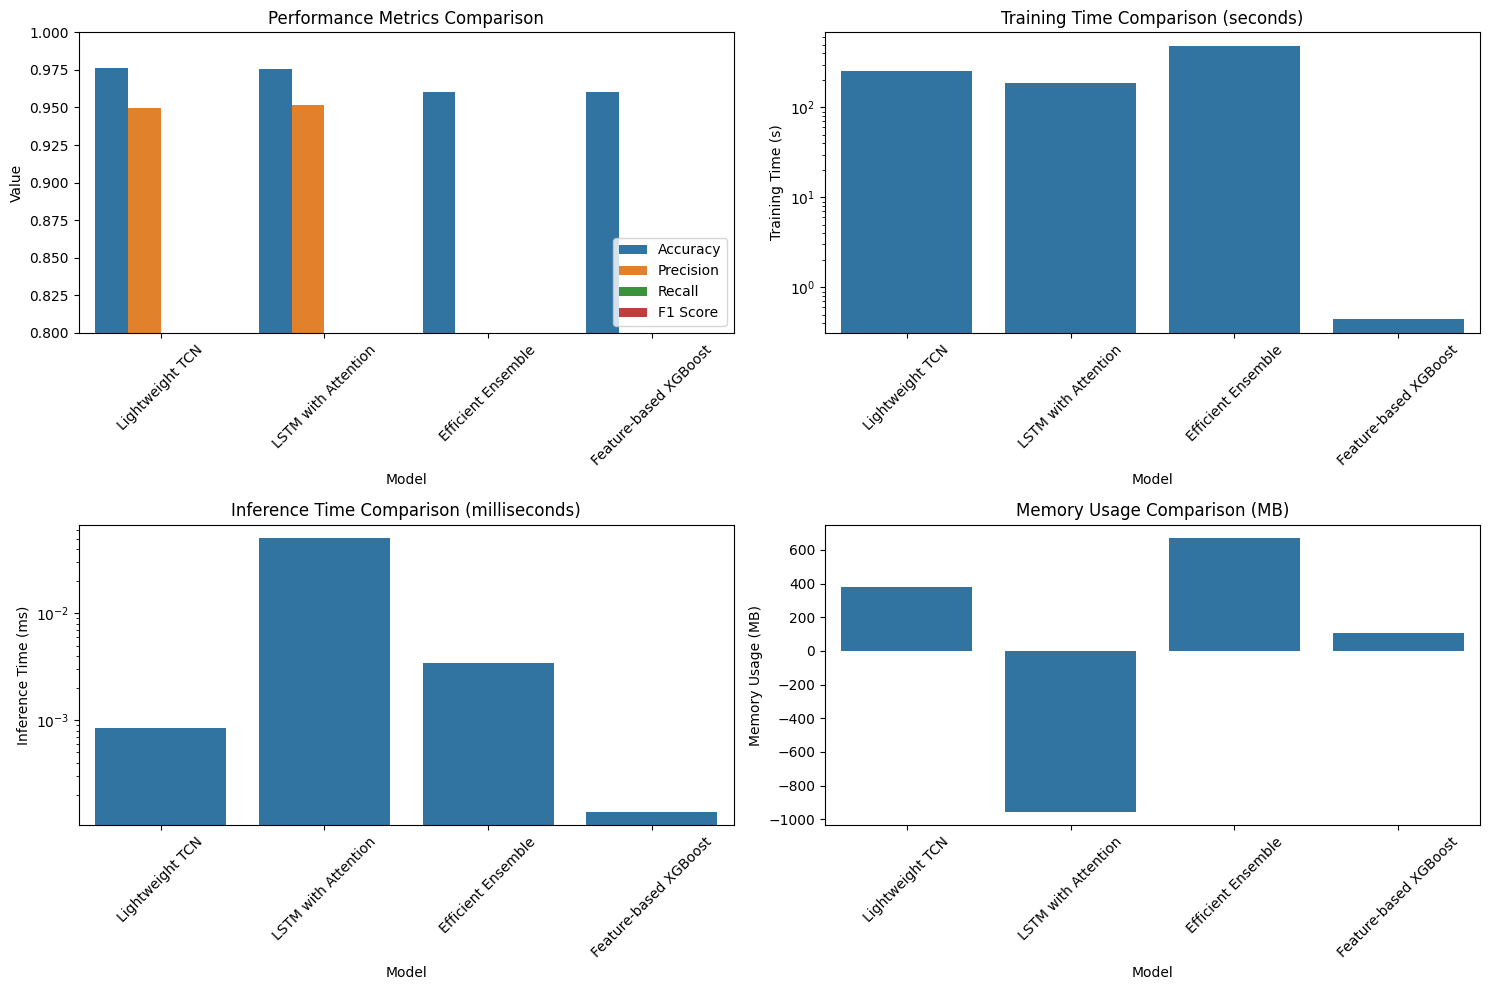

In [22]:
# Get the results dataframe
results_df = evaluator.get_results_df()
print("Model Performance and Efficiency Comparison:")
print(results_df)

# Plot the comparison
evaluator.plot_comparison()

## 9. Save the Best Model

In [23]:
# Determine the best model based on a combination of performance and efficiency
def calculate_efficiency_score(row):
    # Normalize values (higher is better for accuracy, lower is better for time and memory)
    accuracy_norm = row['Accuracy'] / results_df['Accuracy'].max()
    training_time_norm = results_df['Training Time (s)'].min() / row['Training Time (s)']
    inference_time_norm = results_df['Inference Time (ms)'].min() / row['Inference Time (ms)']
    memory_norm = results_df['Memory Usage (MB)'].min() / row['Memory Usage (MB)']

    # Calculate weighted score (adjust weights based on priorities)
    score = 0.5 * accuracy_norm + 0.2 * training_time_norm + 0.2 * inference_time_norm + 0.1 * memory_norm
    return score

# Calculate efficiency score for each model
results_df['Efficiency Score'] = results_df.apply(calculate_efficiency_score, axis=1)

# Sort by efficiency score
results_df_sorted = results_df.sort_values('Efficiency Score', ascending=False)
print("Models ranked by Efficiency Score (balancing accuracy and computational efficiency):")
print(results_df_sorted[['Model', 'Accuracy', 'F1 Score', 'Training Time (s)', 'Inference Time (ms)', 'Memory Usage (MB)', 'Efficiency Score']])

# Get the best model
best_model_name = results_df_sorted.iloc[0]['Model']
print(f"\nBest model based on efficiency score: {best_model_name}")

Models ranked by Efficiency Score (balancing accuracy and computational efficiency):
                   Model  Accuracy  F1 Score  Training Time (s)  \
1    LSTM with Attention  0.975305  0.556959         187.652487   
2     Efficient Ensemble  0.960576  0.000000         482.278139   
0        Lightweight TCN  0.976351  0.584788         251.218613   
3  Feature-based XGBoost  0.960576  0.000000           0.444055   

   Inference Time (ms)  Memory Usage (MB)  Efficiency Score  
1             0.050313        -954.292969          0.600493  
2             0.003449         667.789062          0.357306  
0             0.000849         379.734375          0.281980  
3             0.000140         108.300781          0.010771  

Best model based on efficiency score: LSTM with Attention


In [27]:
# Check if running in Google Colab
import sys
IN_COLAB = 'google.colab' in sys.modules

# Save the best model
import joblib

# Define the paths based on the model type
if IN_COLAB:
    base_path = '/content/best_model'
    scaler_path = '/content/scaler.joblib'
else:
    base_path = 'best_model'
    scaler_path = 'scaler.joblib'

# Get the best model name if it's not defined
# You might need to define this based on your evaluator or previous evaluations
if 'best_model_name' not in locals():
    # Assume LSTM is the best model if not defined
    best_model_name = 'LSTM with Attention'

# Save the appropriate model based on the best model name
if best_model_name == 'Lightweight TCN':
    # For PyTorch models, save the state dict
    model_path = f"{base_path}.pt"
    torch.save(tcn_model.state_dict(), model_path)
    joblib.dump(scaler, scaler_path)
    print(f"Saved TCN model to {model_path}")

elif best_model_name == 'LSTM with Attention':
    # For TensorFlow models, use .keras extension
    model_path = f"{base_path}.keras"
    lstm_model.save(model_path)
    joblib.dump(scaler, scaler_path)
    print(f"Saved LSTM model to {model_path}")

elif best_model_name == 'Efficient Ensemble':
    # For ensemble models, save all component models
    model_path = f"{base_path}.joblib"
    joblib.dump(ensemble_models, model_path)
    joblib.dump(scaler_enhanced, scaler_path)
    print(f"Saved Ensemble model to {model_path}")

elif best_model_name == 'Feature-based XGBoost':
    # For feature-based models, save the selector and model
    model_path = f"{base_path}.joblib"
    joblib.dump(feature_models, model_path)
    joblib.dump(scaler_enhanced, scaler_path)
    print(f"Saved Feature-based model to {model_path}")

# If in Colab, download the model files
if IN_COLAB:
    from google.colab import files
    files.download(model_path)
    files.download(scaler_path)

Saved LSTM model to /content/best_model.keras


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>